In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
csv_path = "/kaggle/input/all-isic-data-20240629/metadata.csv"
image_dir = "/kaggle/input/all-isic-data-20240629/images"

In [3]:
# Load the metadata CSV file
df = pd.read_csv(csv_path)

<ipython-input-3-69404a2efbf1>:2: DtypeWarning: Columns (8,13,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
# Define the 7 specific skin cancer classes to extract
selected_classes = ["melanoma", "nevus", "basal cell carcinoma", "dermatofibroma", "vascular lesion", "pigmented benign keratosis", "actinic keratosis"]
filtered_df = df[df["diagnosis"].isin(selected_classes)]

In [5]:
# Print image counts per class
print("Image count per selected class:")
print(filtered_df["diagnosis"].value_counts())

Image count per selected class:
diagnosis
nevus                         32697
melanoma                       7349
basal cell carcinoma           4921
actinic keratosis              1367
pigmented benign keratosis     1339
dermatofibroma                  420
vascular lesion                 348
Name: count, dtype: int64


In [6]:
# Set max images per class
max_images_per_class = 2000
selected_classes = ["nevus", "basal cell carcinoma", "dermatofibroma", "vascular lesion", "pigmented benign keratosis", "actinic keratosis"]
specific_class = "melanoma"

selected_images = []

# Print initial counts
print("Initial Image Counts:")
initial_counts = filtered_df["diagnosis"].value_counts()
print(initial_counts)

# Select images for the specified classes
for cls in selected_classes:
    class_subset = filtered_df[filtered_df["diagnosis"] == cls]
    selected_subset = class_subset.sample(n=min(max_images_per_class, len(class_subset)), random_state=42)
    selected_images.append(selected_subset)

# Select all images from the specific class
specific_class_subset = filtered_df[filtered_df["diagnosis"] == specific_class]
selected_images.append(specific_class_subset)

# Concatenate all selected subsets
final_df = pd.concat(selected_images).sample(frac=1, random_state=42).reset_index(drop=True)

# Print final counts
print("\nFinal Image Counts:")
final_counts = final_df["diagnosis"].value_counts()
print(final_counts)

# Output CSV path
output_csv = "/kaggle/working/filtered_metadata.csv"

# Save final DataFrame to CSV
final_df.to_csv(output_csv, index=False)


Initial Image Counts:
diagnosis
nevus                         32697
melanoma                       7349
basal cell carcinoma           4921
actinic keratosis              1367
pigmented benign keratosis     1339
dermatofibroma                  420
vascular lesion                 348
Name: count, dtype: int64

Final Image Counts:
diagnosis
melanoma                      7349
basal cell carcinoma          2000
nevus                         2000
actinic keratosis             1367
pigmented benign keratosis    1339
dermatofibroma                 420
vascular lesion                348
Name: count, dtype: int64


In [7]:
# Map diagnoses to binary classes
malignant_classes = ["melanoma"]
benign_classes = ["nevus", "pigmented benign keratosis", "dermatofibroma", "vascular lesion", "basal cell carcinoma", "actinic keratosis"]
df["cancer_category"] = df["diagnosis"].apply(lambda x: "Malignant" if x in malignant_classes else "Benign")

df.to_csv("/kaggle/working/binary_class_metadata.csv", index=False)

In [8]:
print(final_df.columns)

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'benign_malignant',
       'clin_size_long_diam_mm', 'concomitant_biopsy', 'dermoscopic_type',
       'diagnosis', 'diagnosis_confirm_type', 'family_hx_mm',
       'fitzpatrick_skin_type', 'image_type', 'lesion_id', 'mel_class',
       'mel_mitotic_index', 'mel_thick_mm', 'mel_type', 'mel_ulcer',
       'melanocytic', 'nevus_type', 'patient_id', 'personal_hx_mm', 'pixels_x',
       'pixels_y', 'sex'],
      dtype='object')


In [9]:
final_df["cancer_category"] = final_df["diagnosis"].apply(
    lambda x: "Malignant" if x in malignant_classes else "Benign"
)

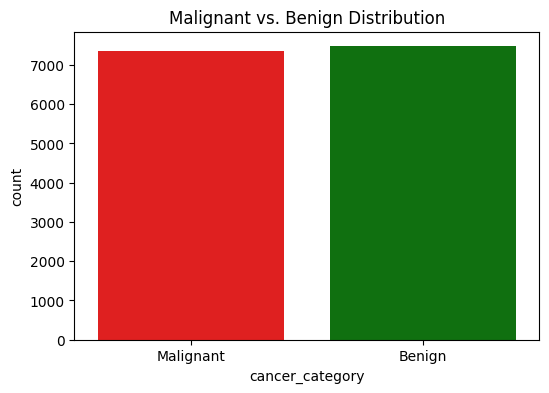

In [10]:
# Data visualization
plt.figure(figsize=(6,4))
sns.countplot(x="cancer_category", data=final_df, palette=["red", "green"])
plt.title("Malignant vs. Benign Distribution")
plt.show()

In [11]:
# Count the number of images in each category
image_counts = final_df['cancer_category'].value_counts()

print(image_counts)


cancer_category
Benign       7474
Malignant    7349
Name: count, dtype: int64


In [12]:
def load_images(dataframe, image_dir, img_size=(224, 224)):
    images, labels = [], []
    for _, row in dataframe.iterrows():
        img_filename = row["isic_id"] + ".jpg"  # Change to .png if needed
        img_path = os.path.join(image_dir, img_filename)
        
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize pixel values
            images.append(img)
            labels.append(1 if row['cancer_category'] == 'Malignant' else 0)
    
    return np.array(images), np.array(labels)

In [13]:
import os
print("Checking directory:", image_dir)
print("Sample image files:", os.listdir(image_dir)[:5])  # Show first 5 images

Checking directory: /kaggle/input/all-isic-data-20240629/images
Sample image files: ['ISIC_2801761.jpg', 'ISIC_0007634.jpg', 'ISIC_0022925.jpg', 'ISIC_0036343.jpg', 'ISIC_4442506.jpg']


In [14]:
print(final_df["isic_id"].head())  # Show first 5 IDs

0    ISIC_0010056
1    ISIC_2553643
2    ISIC_0034782
3    ISIC_0034360
4    ISIC_0067746
Name: isic_id, dtype: object


In [15]:
missing_files = [
    row["isic_id"] + ".jpg" for _, row in final_df.iterrows()
    if not os.path.exists(os.path.join("/kaggle/input/all-isic-data-20240629/images", row["isic_id"] + ".jpg"))
]

print(f"Missing images: {len(missing_files)}")
print(missing_files[:10])  # Show first 10 missing images

Missing images: 0
[]


In [16]:
# Add image filename column if not already present
final_df["image_filename"] = final_df["isic_id"] + ".jpg"

# Verify the column exists before splitting
print(final_df.columns)  # Check available columns
print(final_df.head())   # Check first few rows

# Split dataframe
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)

# Verify the column exists in train_df and test_df
print(train_df.columns)  
print(test_df.columns)

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'benign_malignant',
       'clin_size_long_diam_mm', 'concomitant_biopsy', 'dermoscopic_type',
       'diagnosis', 'diagnosis_confirm_type', 'family_hx_mm',
       'fitzpatrick_skin_type', 'image_type', 'lesion_id', 'mel_class',
       'mel_mitotic_index', 'mel_thick_mm', 'mel_type', 'mel_ulcer',
       'melanocytic', 'nevus_type', 'patient_id', 'personal_hx_mm', 'pixels_x',
       'pixels_y', 'sex', 'cancer_category', 'image_filename'],
      dtype='object')
        isic_id                                        attribution  \
0  ISIC_0010056                                          Anonymous   
1  ISIC_2553643                  Hospital Italiano de Buenos Aires   
2  ISIC_0034782  ViDIR Group, Department of Dermatology, Medica...   
3  ISIC_0034360  ViDIR Group, Department of Dermatology, Medica...   
4  ISIC_0067746                       Hospital Clínic de Barcelona   

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [17]:
import cv2

# Replace 'path_to_image' with the actual path to your image file
image_path = '/kaggle/input/all-isic-data-20240629/images/ISIC_0000006.jpg'

# Load the image using OpenCV
image = cv2.imread(image_path)

# Check if the image is successfully loaded
if image is not None:
    # Get the dimensions of the image
    height, width, channels = image.shape
    print(f"Original shape of the image: Height={height}, Width={width}, Channels={channels}")
else:
    print(f"Failed to load image from {image_path}")


Original shape of the image: Height=767, Width=1022, Channels=3


In [18]:
import os
import shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
image_dir = "/kaggle/input/all-isic-data-20240629/images"  # Original images
test_dir = "/kaggle/working/test_images"  # Test set directory
combined_dir = image_dir  # Used for training/validation generators

# Ensure `image_filename` column exists
if "image_filename" not in final_df.columns:
    final_df["image_filename"] = final_df["isic_id"] + ".jpg"

# Convert labels to binary (0 = Benign, 1 = Malignant)
final_df["cancer_label"] = final_df["cancer_category"].map({"Benign": 0, "Malignant": 1})

# Split dataset into training, validation, and test sets
train_df, temp_df = train_test_split(final_df, test_size=0.2, stratify=final_df["cancer_label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["cancer_label"], random_state=42)

# Convert labels to strings before passing to flow_from_dataframe
train_df["cancer_label"] = train_df["cancer_label"].astype(str)
val_df["cancer_label"] = val_df["cancer_label"].astype(str)
test_df["cancer_label"] = test_df["cancer_label"].astype(str)

# Print class distributions
print(f"Training set class distribution: {train_df['cancer_category'].value_counts().to_dict()}")
print(f"Validation set class distribution: {val_df['cancer_category'].value_counts().to_dict()}")
print(f"Test set class distribution: {test_df['cancer_category'].value_counts().to_dict()}")

# Clear & recreate test directory
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

# Create subdirectories for each class
for label in test_df["cancer_category"].unique():
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Copy test images to new directory
missing_files = []

for _, row in test_df.iterrows():
    src_path = os.path.join(image_dir, row["image_filename"])
    dest_path = os.path.join(test_dir, row["cancer_category"], row["image_filename"])

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        missing_files.append(row["image_filename"])

# Report missing files
print(f"Total missing test files: {len(missing_files)}")
if missing_files:
    print("First 10 missing images:", missing_files[:10])

# ImageDataGenerators (augmentation removed)
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col="image_filename",
    y_col="cancer_label",
    target_size=(300,250),
    batch_size=300,
    class_mode="categorical"
)

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col="image_filename",
    y_col="cancer_label",
    target_size=(300,250),
    batch_size=300,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(300,250),
    batch_size=300,
    class_mode="categorical",
    shuffle=False
)


Training set class distribution: {'Benign': 5979, 'Malignant': 5879}
Validation set class distribution: {'Benign': 747, 'Malignant': 735}
Test set class distribution: {'Benign': 748, 'Malignant': 735}
Total missing test files: 0
Found 11858 validated image filenames belonging to 2 classes.
Found 1482 validated image filenames belonging to 2 classes.
Found 1483 images belonging to 2 classes.


In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
IMG_HEIGHT = 300
IMG_WIDTH = 250
BATCH_SIZE = 300
MAX_EPOCH = 30
model1 = Sequential()

model1.add(Conv2D(16, (7,7), activation='relu',  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model1.add(MaxPooling2D(pool_size=(4, 4)))

model1.add(Conv2D(32, (5,5), activation='relu'))
model1.add(MaxPooling2D(pool_size=(4, 4)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#model1.add(Conv2D(256, (3, 3), activation='relu'))
#model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(GlobalAveragePooling2D())

#model1.add(Dense(512, activation='relu'))
#model1.add(Dropout(0.5))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

model1.add(Dense(2, activation='softmax'))  # For categorical_crossentropy

model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 294, 244, 16)        │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 57, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 17, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,450 (462.70 KB)

 Trainable params: 118,450 (462.70 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('binary_cascading_nv.keras', save_best_only=True, monitor='val_loss', mode='min')


# Train the model
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs= MAX_EPOCH,
    callbacks=[early_stopping, model_checkpoint]  # Include callbacks
    
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 508s 10s/step - accuracy: 0.4957 - loss: 0.6955 - val_accuracy: 0.5040 - val_loss: 0.6932
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 410s 9s/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.5040 - val_loss: 0.6926
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 410s 9s/step - accuracy: 0.5182 - loss: 0.6917 - val_accuracy: 0.6532 - val_loss: 0.6611
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 397s 8s/step - accuracy: 0.5986 - loss: 0.6705 - val_accuracy: 0.6498 - val_loss: 0.6369
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 399s 8s/step - accuracy: 0.6442 - loss: 0.6439 - val_accuracy: 0.6619 - val_loss: 0.6094
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 400s 8s/step - accuracy: 0.6735 - loss: 0.6193 - val_accuracy: 0.6991 - val_loss: 0.5964
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 402s 8s/step - accuracy: 0.6907 - loss: 0.5981 - val_accuracy: 0.6734 - val_loss: 0.5991
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 398s 8s/step - accuracy: 0.7074 - loss: 0.5815 - val_accuracy: 0.7139 - val_loss: 0

In [21]:
test_loss, test_acc = model1.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.7643 - loss: 0.4784
Test Accuracy: 76.87%


In [22]:
# Save everything (architecture + weights + optimizer state)
model1.save('/kaggle/working/isic_binary_classification.keras')

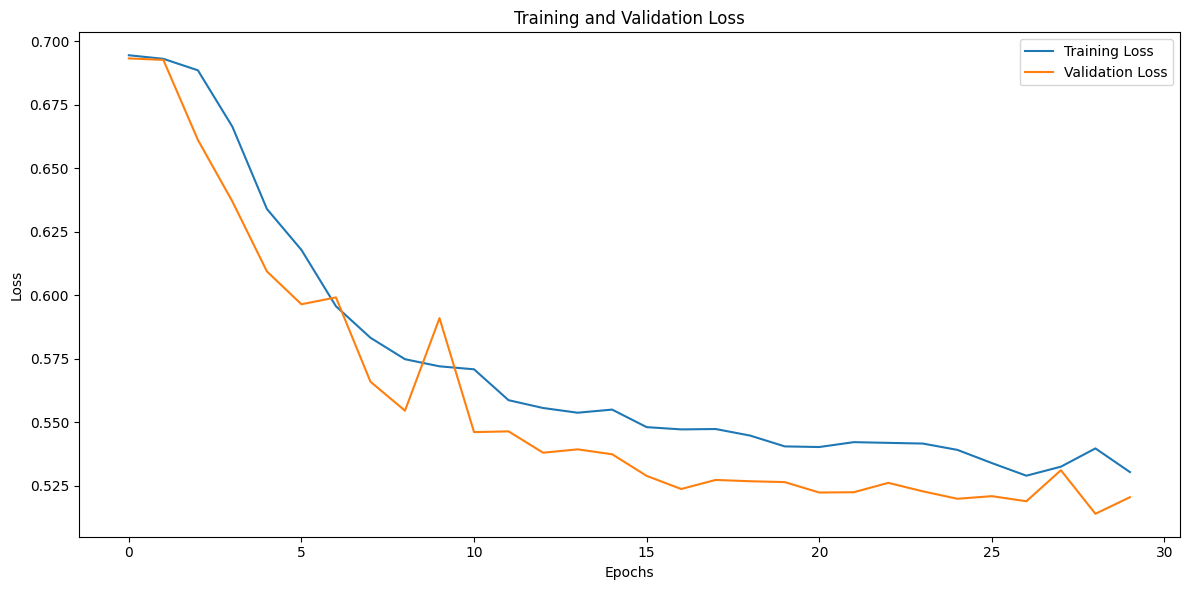

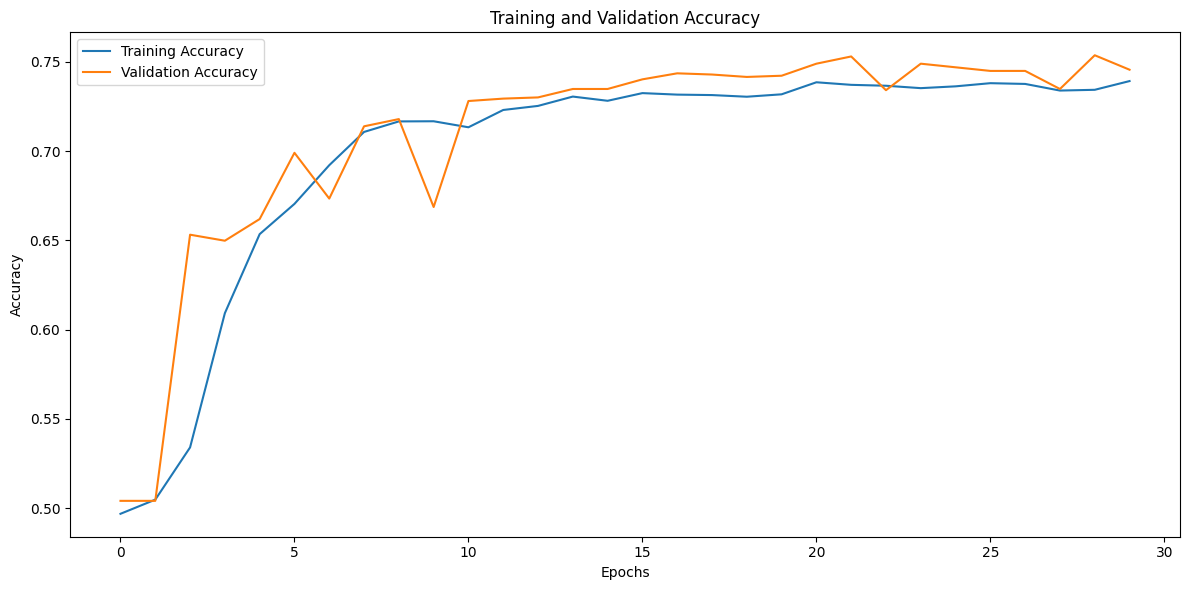

In [24]:
import matplotlib.pyplot as plt
import os

# Create the directory if it doesn't exist
save_dir = "/kaggle/working/results"
os.makedirs(save_dir, exist_ok=True)

# --- Plot and Save Training & Validation Loss ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#loss_path = os.path.join(save_dir, "ISIC_2CLASS_loss_curve.png")
#plt.savefig(loss_path)
plt.show()
plt.close()

# --- Plot and Save Training & Validation Accuracy ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#acc_path = os.path.join(save_dir, "ISIC_2_accuracy_curve.png")
#plt.savefig(acc_path)
plt.show()
plt.close()

#print(f"✅ Saved loss and accuracy plots to:\n- {loss_path}\n- {acc_path}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step


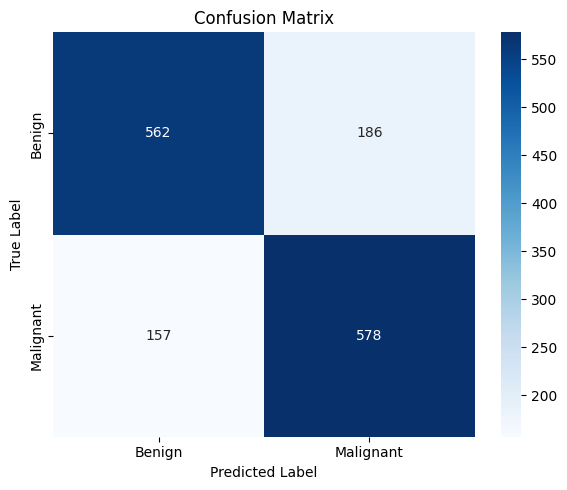

Classification Report:

              precision    recall  f1-score   support

      Benign       0.78      0.75      0.77       748
   Malignant       0.76      0.79      0.77       735

    accuracy                           0.77      1483
   macro avg       0.77      0.77      0.77      1483
weighted avg       0.77      0.77      0.77      1483



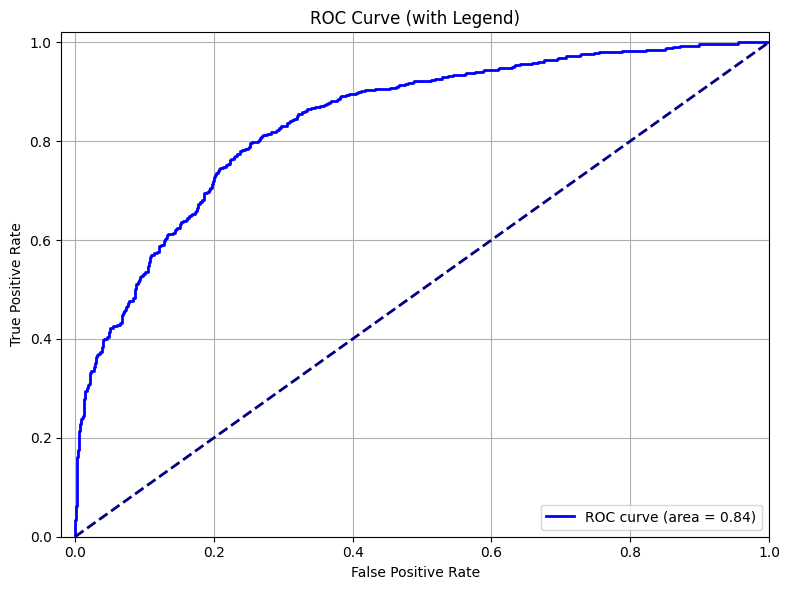

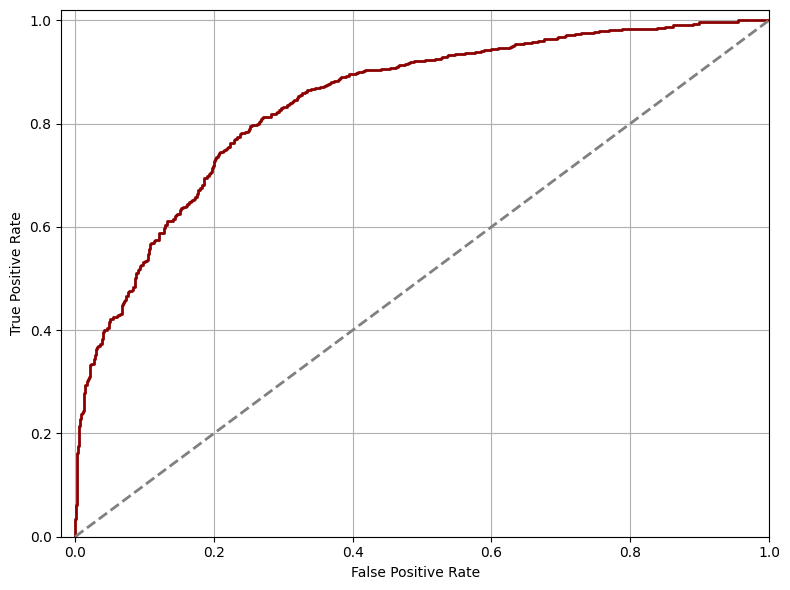


✅ All results saved in: /kaggle/working/results


In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- Setup ---
save_dir = "/kaggle/working/results"
os.makedirs(save_dir, exist_ok=True)

# --- Predictions ---
y_pred_probs = model1.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)  # For multi-class use
y_true = test_generator.classes

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "ISIC-2_confusion_matrix.png"))
plt.show()
plt.close()

# --- Classification Report ---
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:\n")
print(report)

with open(os.path.join(save_dir, "ISIC-2_classification_report.txt"), "w") as f:
    f.write("Classification Report\n")
    f.write("=====================\n\n")
    f.write(report)

# --- ROC Curve (binary only) ---
if y_pred_probs.shape[1] == 2:  # Ensure binary classification
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    # With legend
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (with Legend)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "ISIC-2_roc_curve_with_legend.png"))
    plt.show()
    plt.close()

    # Without legend
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkred', lw=2)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
   # plt.title("ROC Curve (No Legend)")
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "ISIC-2_roc_curve_no_legend.png"))
    plt.show()
    plt.close()

print(f"\n✅ All results saved in: {save_dir}")
